In [1]:
import pandas as pd 
import numpy as np
import datetime
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('GBPUSD60.csv',names=['date','time','open','high','low','close','quoteVolume'])
a = data.date +' '+ data.time
data.set_index(pd.to_datetime(a),inplace=True)
data.drop(['date','time'],axis=1,inplace=True)

In [3]:
def make_Xy():
    data = pd.read_csv('GBPUSD60.csv',names=['date','time','open','high','low','close','quoteVolume'])
    a = data.date +' '+ data.time
    data.set_index(pd.to_datetime(a),inplace=True)
    data.drop(['date','time'],axis=1,inplace=True)

    price = ['open','close','high','low']
    data['price'] = data[price].mean(axis=1)
    data['price_change'] = data.price.pct_change()
    data['spread']  = data.open - data.close

    data['next'] = data.price.shift(1)
    data['change'] = (data.next - data.price)
    data.drop(price,axis=1,inplace=True)

    pos = np.percentile(data.change.dropna(),50 + 25)
    neg = np.percentile(data.change.dropna(),50- 25)
    
    def up_down(row):
        """returns if the next movement or up or down"""
        if row > pos:
            return 1
        elif row < neg:
            return -1
        else:
            return 0   

    data['up_down'] = data.change.apply(up_down)
    ### creating the SMAs
    data['sma_5'] = data['price'].rolling(5).mean()
    data['sma_10'] = data['price'].rolling(10).mean()

    data['mean_spread3'] = data['spread'].rolling(3).mean()
    data['mean_spread6'] = data['spread'].rolling(5).mean()


    data['mean_quote_volume3'] = data['quoteVolume'].rolling(3).mean()
    data['mean_quote_volume5'] = data['quoteVolume'].rolling(5).mean()

    data['pc_ch_5'] = data.sma_5.pct_change()
    data['pc_ch_10'] = data.sma_10.pct_change()

    data['sma5_ask_diff'] = (data.sma_5  - data.price)
    data['sma10_ask_diff'] = (data.sma_10  - data.price)

    data.dropna(inplace=True)


    X = data.drop(['change','up_down','next','price','sma_5','sma_10'],axis=1)
    X = X.values
    y = data.up_down.values
    return data,X,y

In [4]:
data, X , y = make_Xy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [6]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
lda=LinearDiscriminantAnalysis(n_components=4)

In [9]:
X_train_lda = lda.fit_transform(X_train_std,y_train)
X_test_lda = lda.transform(X_test_std)
lda.n_components

/home/data-sci/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


4

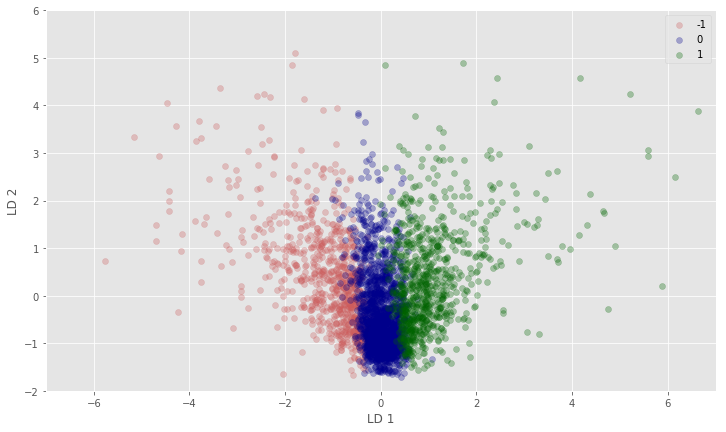

In [24]:
def vis():
    plt.figure(figsize=(12,7))
    colors = ['indianred', 'darkblue', 'darkgreen']
    for l, c in zip(np.unique(y_train), colors):
         plt.scatter(X_train_lda[y_train==l, 0],
             X_train_lda[y_train==l, 1],
             c=c, label=l,alpha=0.3)

    plt.xlim(-7,7)
    plt.ylim(-2,6)
    plt.xlabel('LD 1')
    plt.ylabel('LD 2')
    plt.legend(loc='upper right')
vis()

In [10]:
lda.explained_variance_ratio_

array([ 0.8167839,  0.1832161])

In [11]:
model = RandomForestClassifier(n_estimators=100).fit(X_train_lda,y_train)

In [12]:
y_pred = model.predict(X_test_lda)
confusion_matrix(y_test, y_pred)

array([[184,  21,   0],
       [ 20, 375,  17],
       [  0,  28, 185]])

In [13]:
accuracy_score(y_test,y_pred)

0.89638554216867472

In [14]:
from xgboost import XGBClassifier


xg = XGBClassifier(n_estimators=1000)

In [15]:
xg.fit(X_train_lda,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [16]:
y_pred = xg.predict(X_test_lda)
confusion_matrix(y_test, y_pred)

array([[188,  17,   0],
       [ 22, 370,  20],
       [  0,  25, 188]])

In [17]:
accuracy_score(y_test,y_pred)

0.89879518072289155

In [18]:
from sklearn.svm import SVC
svc = SVC()

In [19]:
svc.fit(X_train_lda,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
y_pred = svc.predict(X_test_lda)
confusion_matrix(y_test, y_pred)

array([[184,  20,   1],
       [ 18, 379,  15],
       [  0,  21, 192]])

In [21]:
accuracy_score(y_test,y_pred)

0.90963855421686746

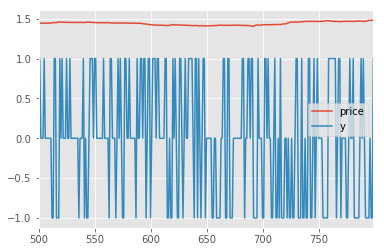

In [22]:
df = pd.DataFrame({'price':data.price.values,'y':y})
df.iloc[500:800,:].plot()